In [1]:
import numpy as np
from grid import Grid

g = Grid()
g.print()

-------------------------------
| 0,0 | 1,0 | 2,0 | 3,0 | 4,0 | 
-------------------------------
| 0,1 | 1,1 | 2,1 | 3,1 | 4,1 | 
-------------------------------
| 0,2 | 1,2 | 2,2 | 3,2 | 4,2 | 
-------------------------------
| 0,3 | 1,3 | 2,3 | 3,3 | 4,3 | 
-------------------------------
| 0,4 | 1,4 | 2,4 | 3,4 | 4,4 | 
-------------------------------


In [2]:
e_star = 0.3

# Q-Learning

In [3]:
from actors import QLearning

q = QLearning(g)
q.run(epsilon=e_star)

print('Steps:', q.steps)
print('Rewards:', q.totalReward)

Steps: 1768
Rewards: -206


In [4]:
for episodes in range(2000):
    q.resetCount()
    q.run(epsilon=e_star)

print('Episodes:', episodes)
print('Steps:', q.steps)
print('Rewards:', q.totalReward)

Episodes: 1999
Steps: 12
Rewards: 8


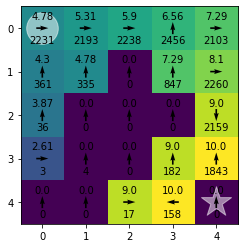

In [5]:
q.plot()

# Geradores

## Política

<AxesSubplot: >

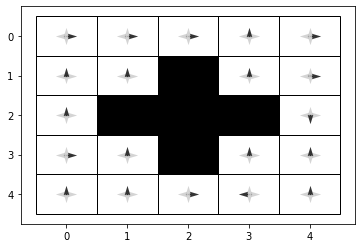

In [6]:
def generatePi(q, g, e=0.1):
    # if not(0 < e < 1):
    #     return -np.inf
    p_a = lambda a, s: (e/4, 1-e+e/4)[a == max(q[s], key=q[s].get)] if 0 < e < 1 else 1e-10
    pi = np.array([[p_a(a, s) for a in g.ACTIONS] for s in g.S])
    return pi.reshape(g.size[0], g.size[1], len(g.ACTIONS), order='F')

pi_star = generatePi(q.Q, g, e_star)

from plot import plotPolicy
plotPolicy(pi_star, g)

## Trajetória

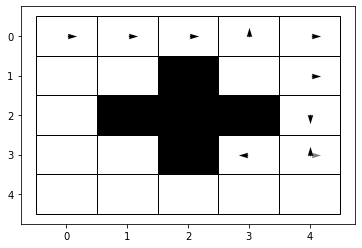

In [7]:
import random
def generateTrajetory(pi, g,  kind=0, size=10):
    s = (0,0)

    arr = []
    for t in range(size):
        a  = random.choices(g.ACTIONS, pi[s], k=1)[0]
        if kind in ['values', 0]:
            step =  (s, a)
        elif kind in ['indexes', 1]:
            step =  (g.S.index(s), g.ACTIONS.index(a))
        elif kind in ['states values', 2]:
            step =  (s, g.ACTIONS.index(a))
        elif kind in ['action values', 3]:
            step =  (g.S.index(s), a)

        s,_,_ = g.transition(s,  a)

        arr.append(step)

    return arr

from plot import plotTrajectory
plotTrajectory(generateTrajetory(pi_star, g), g)

trajectory_pi_star = generateTrajetory(pi_star, g, 2)

# Estimadores

## Likelihood
$\mathcal{L}$($\pi$|$\xi$) = $\sum_{t=1}^{T}$ log $\pi$(a<sub>t</sub>|s<sub>t</sub>) 
<br><br>
$T$ = |$\xi$|

In [8]:
def likelihood(pi, e):
    arr = [np.log(pi[x,y][a]) for (x,y), a in e]
    return np.sum(arr)

likelihood(pi_star, trajectory_pi_star)

-9.555047243739011

## Contagem
$ \hat{p}(\pi|\xi) = \frac{\sum_{s,a\:in\:\xi}n(A, s)}{|\xi|} $ 
<br>
$ A \gets argmax_a(\pi(a|s))$ 

In [25]:
def counting(pi, e):
    return sum(1 for s,a in e if a==np.argmax(pi[s])) / len(e)

counting(pi_star, trajectory_pi_star)

0.7

## Teste de Sanidade

In [9]:
es = [0.9, 0.1, 0.5] + [e_star] # e_star = 0.3
pis = [generatePi(q.Q, g, e) for e in es]

likes = [likelihood(pi, trajectory_pi_star) for pi in pis]
p = np.argmax(likes)

print(f'Maior: {p}\n', likes)

Maior: 2
 [-12.34247530689995, -11.612369152629793, -9.528350029759654, -9.555047243739011]


### Com $n$ trajetórias:

$\sum^{n}$ $\mathcal{L}$($\pi$|$\xi$)

In [10]:
es = [0.9, 0.1, 0.5]+[e_star] # e_star = 0.3

def exp():
    trajectory = generateTrajetory(pi_star, g, 2, 10)
    pis = [generatePi(q.Q, g, e) for e in es] 
    likes = np.array([likelihood(pi, trajectory_pi_star) for pi in pis])
    return likes


n = 1000
exps = [exp() for _ in range(n)]
print(np.argmax(np.sum(exps, axis=0)))
print(np.sum(exps, axis=0))

# freq = [np.mean([int(np.argmax(v)==i) for v in exps])for i in range(len(es))]
# print(freq)


2
[-12342.4753069  -11612.36915263  -9528.35002976  -9555.04724374]


## Gradiente Descendente

### Calculo do Gradiente:
$\nabla$ $\mathcal{L}$($\pi$|$\xi$) = $\sum_{t=1}^{T}$ $\frac{1}{\pi}$ $\frac{\partial \pi}{\partial \xi}$ 
<br><br>
$T$ = |$\xi$|
<br> e <br>
$\pi \gets \{^{1-\epsilon + \frac{\epsilon}{|A|} \: se \: a_t = a^*}_{\frac{\epsilon}{|A|}  \: se \: a_t \ne a^*}$
<br>Logo<br>
$\frac{\partial \pi}{\partial \xi} \gets \{^{-1 + \frac{1}{|A|} \: se \: a_t = a^*}_{\frac{1}{|A|}  \: se \: a_t \ne a^*}$


In [11]:
def gradient(pi, trajectory, q_values, g):
    arr = [1/pi[x,y,a] * (.25, -.75)[g.ACTIONS[a]==max(q_values[(x,y)], key=q_values[(x,y)].get)] for (x,y),a in trajectory]
    return np.sum(arr)

### Calculo do Gradiente Descendente 

$\theta \gets \theta + \alpha \sum^{T-1}_{t=0} \nabla_{\theta} log \pi_{\theta}(a_t|s_t)$ 
<br><br>
<br>
$\alpha_{t+1} \gets \{^{\alpha_t + \frac{\alpha_t}{1+dt}  \: se \: \mathcal{L}(\pi_{\theta}|\xi) \ge \mathcal{L}(\pi_{\theta-1}|\xi) }_{\alpha_t - \frac{\alpha_t}{1+dt}  \: se \: \mathcal{L}(\pi_{\theta}|\xi) < \mathcal{L}(\pi_{\theta-1}|\xi) }$
<br>
$d =$ Decay
<br><br>
$\bar{e} = \sqrt{(\mathcal{L}(\pi_{\theta}|\xi) - \mathcal{L}(\pi_{\theta-1}|\xi))^2}$\
<br><br>
$T = 10000$
<br>
com parada em $\bar{e} \le 0.0001$

In [15]:
import random 

def GradientDescent(trajectory, q_values, g, param=None, learning_rate=.01, decay=.9, precision=1e-4, max_trials=10000):
    """
        Leaning Rate is changed with a Time-based learning schedule
    """
    if param is None:
        param = random.random()

    error = 1+precision
    trials = 0

    pi = generatePi(q_values, g, param)
    l = likelihood(pi, trajectory)
    while (error > precision) and (trials <= max_trials):
        trials += 1
        new_param = param + learning_rate * gradient(pi, trajectory, q_values, g)
        new_pi = generatePi(q_values, g, new_param)
        new_l = likelihood(new_pi, trajectory)
        error = np.abs(new_l - l)
        if new_l >= l:
            # learning_rate += (learning_rate * 0.2) 
            learning_rate += learning_rate / (1+decay*trials)
            pi = new_pi
            l = new_l
            param = new_param
        else:
            # learning_rate -= (learning_rate * 0.2)
            learning_rate -= learning_rate / (1+decay*trials)
            
        yield param, trials, error

def execute(f, all=False):
    result = [(param, trial, error) for param, trial, error  in f]
    return result if all else result[-1]
        
data = execute(GradientDescent(generateTrajetory(pi_star, g, 2, 10), q.Q, g), all=True)
print('estimative', data[-1])

estimative (0.2668152805514378, 6, 3.124583681568538e-06)


Text(0.5, 0, 'trial')

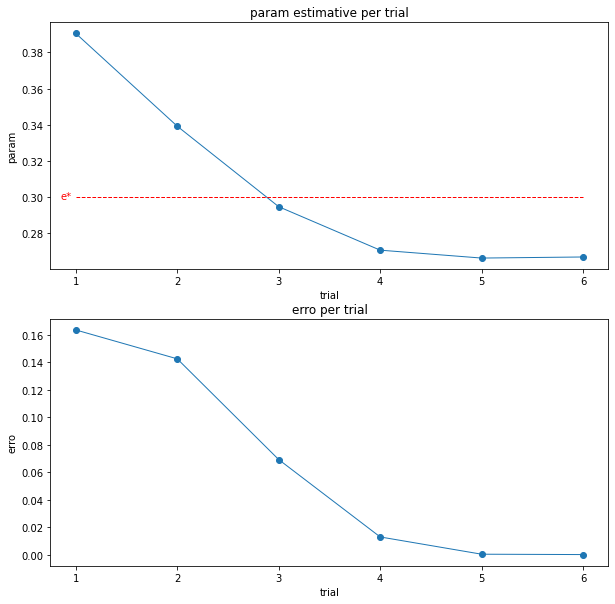

In [16]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2,1, figsize=(10,10))

axs[0].plot([item[1] for item in data], [item[0] for item in data], linewidth=1, marker='o')
axs[0].plot([item[1] for item in data], [e_star for _ in range(len(data))], linewidth=1, linestyle='dashed', color='red')
axs[0].text(.85, e_star-1e-3, 'e*', color='red')
axs[0].set_title(f'param estimative per trial')
axs[0].set_ylabel('param')
axs[0].set_xlabel('trial')


axs[1].plot([item[1] for item in data], [item[2] for item in data], linewidth=1, marker='o')
axs[1].set_title(f'erro per trial')
axs[1].set_ylabel('erro')
axs[1].set_xlabel('trial')

### Média em $n$ Vezes

Text(0.5, 0, 'size of trajectory')

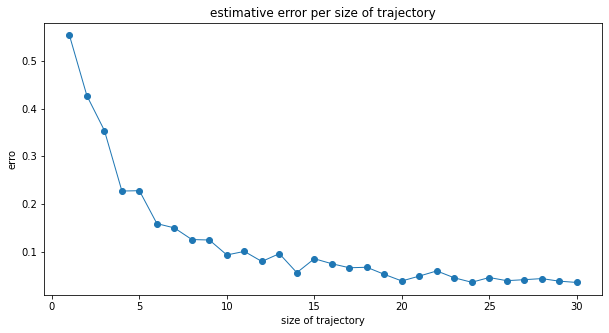

In [17]:
fig, axs = plt.subplots(1,1, figsize=(10,5))

n = 100
trajectory_size = 30
x = [n+1 for n in range(trajectory_size)]

sums = np.zeros(trajectory_size, dtype='float64')

for i in range(n):
    exps = np.array([execute(GradientDescent(generateTrajetory(pi_star, g, 2, t+1), q.Q, g))[0] for t in range(trajectory_size)])
    sums += (e_star-exps)**2
    
y = sums/trajectory_size

axs.plot(x,y, linewidth=1, marker='o')
axs.set_title(f'estimative error per size of trajectory')
axs.set_ylabel('erro')
axs.set_xlabel('size of trajectory')

# [(e_star-item[1])**2 for item in exps]
# exps